In [127]:
# pip install lightgbm
# pip install ipywidgets

In [233]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.utils import shuffle
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time

from lightgbm import LGBMClassifier

try:
    # To enable interactive mode you should install ipywidgets
    # pip install ipywidgets
    from ipywidgets import interact, SelectMultiple
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False

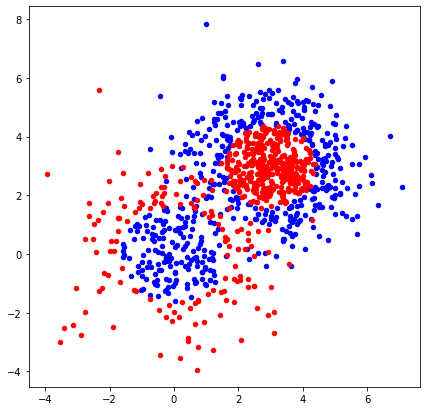

In [160]:
X1, y1 = datasets.make_gaussian_quantiles(cov=2.,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = datasets.make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=700, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))
y = 2*y-1

Xblue = X[y==-1]
Xred = X[y==1]
plt.figure(figsize=(7,7))
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20)

In [175]:
def shuffle_split(X,y,k):
    if k<0 or k>1:
        print("Error : Parameter k must be between 0 and 1.")
        return 0
    
    n=len(X)
    
    X, y = shuffle(X, y)
    
    X_train, X_test = np.split(X,[int(n*k)])
    y_train, y_test = np.split(y,[int(n*k)])
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = shuffle_split(X,y,0.8)

In [162]:
model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = 7,
                       max_depth = 4,
                       learning_rate = 0.1,
                       n_estimators = 100,
                       objective='binary')

metrics = ['binary_logloss','auc']

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          early_stopping_rounds = 5,
          verbose = 10,
          feature_name = ['X','Y'])

Training until validation scores don't improve for 5 rounds
[10]	Training data's binary_logloss: 0.39115	Training data's auc: 0.952756	Test data's binary_logloss: 0.437115	Test data's auc: 0.908816
[20]	Training data's binary_logloss: 0.289233	Training data's auc: 0.9746	Test data's binary_logloss: 0.357807	Test data's auc: 0.934524
[30]	Training data's binary_logloss: 0.235339	Training data's auc: 0.981549	Test data's binary_logloss: 0.31921	Test data's auc: 0.943555
[40]	Training data's binary_logloss: 0.197837	Training data's auc: 0.987693	Test data's binary_logloss: 0.295956	Test data's auc: 0.950534
[50]	Training data's binary_logloss: 0.170639	Training data's auc: 0.990313	Test data's binary_logloss: 0.280097	Test data's auc: 0.955768
[60]	Training data's binary_logloss: 0.152449	Training data's auc: 0.991828	Test data's binary_logloss: 0.269302	Test data's auc: 0.959154
Early stopping, best iteration is:
[57]	Training data's binary_logloss: 0.156995	Training data's auc: 0.991621

LGBMClassifier(max_depth=4, num_leaves=7, objective='binary')

In [163]:
def render_metric(metric_name):
    ax = lgb.plot_metric(model.evals_result_, metric=metric_name, figsize=(10, 5))
    plt.show()

In [164]:
if INTERACTIVE:
    # create widget to switch between metrics
    interact(render_metric, metric_name=metrics)
else:
    for metric in metrics:
        render_metric(metric)

interactive(children=(Dropdown(description='metric_name', options=('binary_logloss', 'auc'), value='binary_log…

In [166]:
ypred = model.predict(X_test)

matrix = confusion_matrix(y_test, ypred)
print(matrix)

print(model.score(X_test, y_test))

[[ 78   6]
 [ 16 100]]
0.89


In [167]:
def plot_decision_boundary(model, X, y, fig_size=(7,7)):
    plot_step = 0.02
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, plot_step), np.arange(x1_min, x1_max, plot_step))
    yypred = model.predict(np.c_[xx0.ravel(),xx1.ravel()])
    yypred = yypred.reshape(xx0.shape)
    plt.figure(figsize=fig_size)
    plt.contourf(xx0, xx1, yypred, cmap=plt.cm.Paired)
    y_pred = model.predict(X)
    Xblue_good = X[np.equal(y,-1)*np.equal(y,y_pred)]
    Xblue_bad  = X[np.equal(y,-1)*np.not_equal(y,y_pred)]
    Xred_good  = X[np.equal(y,1)*np.equal(y,y_pred)]
    Xred_bad   = X[np.equal(y,1)*np.not_equal(y,y_pred)]
    plt.scatter(Xblue_good[:,0],Xblue_good[:,1],c='b',s=20)
    plt.scatter(Xblue_bad[:,0],Xblue_bad[:,1],c='c',marker='v',s=20)
    plt.scatter(Xred_good[:,0],Xred_good[:,1],c='r',s=20)
    plt.scatter(Xred_bad[:,0],Xred_bad[:,1],c='m',marker='v',s=20)
    plt.show()

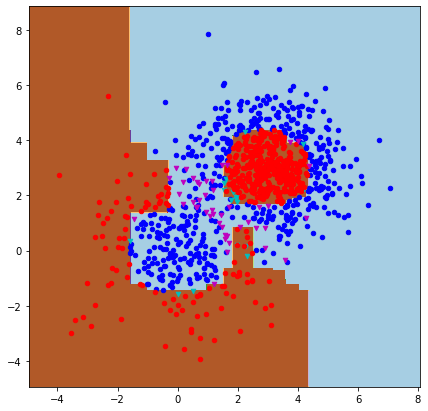

In [168]:
plot_decision_boundary(model,X,y)

In [170]:
def render_tree(tree_index, show_info, precision=3):
    show_info = None if 'None' in show_info else show_info
    return lgb.create_tree_digraph(model, tree_index=tree_index,
                                   show_info=show_info, precision=precision)

In [173]:
if INTERACTIVE:
    # create widget to switch between trees and control info in nodes
    interact(render_tree,
             tree_index=(0, gbm.num_trees() - 1),
             show_info=SelectMultiple(  # allow multiple values to be selected
                 options=['None',
                          'split_gain',
                          'internal_count',
                          'data_percentage'],
                 value=['None']),
             precision=(0, 4))
    tree = None
else:
    tree = render_tree(53, ['None'])
tree

interactive(children=(IntSlider(value=37, description='tree_index', max=74), SelectMultiple(description='show_…

## Examples

#### NIST

In [199]:
from sklearn import datasets

digits = datasets.load_digits()
#print(digits.DESCR)

X = digits.data
Y = digits.target

X_train,y_train,X_test,y_test = shuffle_split(X,Y,0.75)

In [200]:
model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = 7,
                       max_depth = 4,
                       learning_rate = 0.1,
                       n_estimators = 100,
                       objective='multiclass')

metrics = ['multi_logloss']

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          early_stopping_rounds = 5,
          verbose = 10)

Training until validation scores don't improve for 5 rounds
[10]	Training data's multi_logloss: 0.452072	Test data's multi_logloss: 0.571061
[20]	Training data's multi_logloss: 0.152052	Test data's multi_logloss: 0.269039
[30]	Training data's multi_logloss: 0.0567579	Test data's multi_logloss: 0.170271
[40]	Training data's multi_logloss: 0.02266	Test data's multi_logloss: 0.127905
[50]	Training data's multi_logloss: 0.00952297	Test data's multi_logloss: 0.108438
[60]	Training data's multi_logloss: 0.00416586	Test data's multi_logloss: 0.094934
[70]	Training data's multi_logloss: 0.00186383	Test data's multi_logloss: 0.0903048
[80]	Training data's multi_logloss: 0.000850756	Test data's multi_logloss: 0.0900477
[90]	Training data's multi_logloss: 0.000394904	Test data's multi_logloss: 0.0875665
[100]	Training data's multi_logloss: 0.000185036	Test data's multi_logloss: 0.0852786
Did not meet early stopping. Best iteration is:
[100]	Training data's multi_logloss: 0.000185036	Test data's m

LGBMClassifier(max_depth=4, num_leaves=7, objective='multiclass')

In [203]:
if INTERACTIVE:
    # create widget to switch between metrics
    interact(render_metric, metric_name=metrics)
else:
    for metric in metrics:
        render_metric(metric)
        
print('Training score : {}'.format(round(model.score(X_train,y_train),3)))
print('Genralization score : {}'.format(round(model.score(X_test,y_test),3)))

interactive(children=(Dropdown(description='metric_name', options=('multi_logloss',), value='multi_logloss'), …

Training score : 1.0
Genralization score : 0.973


#### Wine

In [204]:
wine = datasets.load_wine()
#print(wine.DESCR)

X = wine.data
Y = wine.target

X_train,y_train,X_test,y_test = shuffle_split(X,Y,0.75)

In [205]:
model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = 7,
                       max_depth = 4,
                       learning_rate = 0.1,
                       n_estimators = 100,
                       objective='multiclass')

metrics = ['multi_logloss']

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          early_stopping_rounds = 5,
          verbose = 10)

Training until validation scores don't improve for 5 rounds
[10]	Training data's multi_logloss: 0.323846	Test data's multi_logloss: 0.386082
[20]	Training data's multi_logloss: 0.126187	Test data's multi_logloss: 0.179839
[30]	Training data's multi_logloss: 0.0507877	Test data's multi_logloss: 0.0863606
[40]	Training data's multi_logloss: 0.0211735	Test data's multi_logloss: 0.0411224
[50]	Training data's multi_logloss: 0.00842261	Test data's multi_logloss: 0.0206304
[60]	Training data's multi_logloss: 0.00346563	Test data's multi_logloss: 0.0106843
[70]	Training data's multi_logloss: 0.00147213	Test data's multi_logloss: 0.00621676
[80]	Training data's multi_logloss: 0.000608018	Test data's multi_logloss: 0.00385367
[90]	Training data's multi_logloss: 0.000256116	Test data's multi_logloss: 0.00240723
[100]	Training data's multi_logloss: 0.000112825	Test data's multi_logloss: 0.00167456
Did not meet early stopping. Best iteration is:
[100]	Training data's multi_logloss: 0.000112825	Tes

LGBMClassifier(max_depth=4, num_leaves=7, objective='multiclass')

In [206]:
if INTERACTIVE:
    # create widget to switch between metrics
    interact(render_metric, metric_name=metrics)
else:
    for metric in metrics:
        render_metric(metric)
        
print('Training score : {}'.format(round(model.score(X_train,y_train),3)))
print('Genralization score : {}'.format(round(model.score(X_test,y_test),3)))

interactive(children=(Dropdown(description='metric_name', options=('multi_logloss',), value='multi_logloss'), …

Training score : 1.0
Genralization score : 1.0


## Comparaison XGBoost et LightGBM

In [227]:
dataframe=pd.read_csv("./archive/creditcard.csv",sep=',')

X = dataframe.drop(['Class'], axis=1)
y = dataframe['Class']

print(X.shape)
print(y.shape)

dataframe.head()

(284807, 30)
(284807,)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [237]:
X_train,y_train,X_test,y_test = shuffle_split(X,y,0.7)

model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = 7,
                       max_depth = 4,
                       learning_rate = 0.1,
                       n_estimators = 25,
                       objective='binary')

metrics = ['binary_logloss','auc']

start = time.time()

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          #early_stopping_rounds = 10,
          verbose = 10)

end = time.time()
print('Elapsed time : {}s'.format(round(end-start,3)))

[10]	Training data's binary_logloss: 0.0128825	Training data's auc: 0.851075	Test data's binary_logloss: 0.0213166	Test data's auc: 0.763704
[20]	Training data's binary_logloss: 0.0167145	Training data's auc: 0.873084	Test data's binary_logloss: 0.0300563	Test data's auc: 0.770275
Elapsed time : 2.132s
